# Building the SVM model for classifying DDoS and PortScanning

## Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

## Save the scaler object

In [3]:
scaler = StandardScaler(with_mean=True)

---

## Helper Functions

In [4]:
# updated print_confusion_matrix for multi-class classification
def printConfusionMatrix(cm, y_true, normalize=False):
    # get unique class labels
    labels = sorted(set(y_true))

    # visualize the confusion matrix with a heatmap
    plt.figure(figsize=(8, 6))  # set figure size
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap='Blues',
                xticklabels=labels, yticklabels=labels, cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix Heatmap')
    plt.show()


# function to calculate TP, FP, FN, TN for each class
def calculateMetrics(cm):
    """
    Calculate True Positives, False Positives, False Negatives, and True Negatives
    for each class using the confusion matrix.
    """
    metrics = {}
    for classIdx in range(len(cm)):
        tp = cm[classIdx, classIdx]
        fp = cm[:, classIdx].sum() - tp
        fn = cm[classIdx, :].sum() - tp
        tn = cm.sum() - (tp + fp + fn)
        metrics[classIdx] = {"TP": tp, "FP": fp, "FN": fn, "TN": tn}
    return metrics


# function to scale specific columns in the data using Standard Scaler
def scaleData(scaler, X_train, X_test, columns_to_scale):
    # make a copy of the data to avoid modifying the original DataFrame
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # fit and transform the specified columns for X_train
    X_train_scaled[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])
    # transform only for X_test (using the fit from X_train)
    X_test_scaled[columns_to_scale] = scaler.transform(X_test[columns_to_scale])
    joblib.dump(scaler, 'standard_scaler.pkl')

    # return the scaled dataframes
    return X_train_scaled, X_test_scaled

# function for selecting
def filterBenignValues(dataframe, filterAmount):
    # separate benign rows and non-benign rows
    benign_rows = dataframe[dataframe['Label'] == 'BENIGN']
    non_benign_rows = dataframe[dataframe['Label'] != 'BENIGN']

    # randomly select half of the benign rows
    benign_sample = benign_rows.sample(frac = filterAmount, random_state = 42)  # Adjust random_state for reproducibility

    # combine and return the sampled benign rows with all non-benign rows
    result_df = pd.concat([benign_sample, non_benign_rows])
    return result_df

# function for counting the number of different label types and plotting the result
def count_and_plot(y, labelValues = ['Benign', 'DoS', 'DDoS', 'Port Scanning']):
    # count the number of rows for each label
    labelCounts = y.value_counts().sort_index()

    # calculate additional counts
    countBenign = labelCounts[0] if 0 in labelCounts.index else 0
    countOthers = labelCounts.drop(0).sum() if 0 in labelCounts.index else labelCounts.sum()

    # plot the counts
    plt.figure(figsize=(8, 6))
    plt.bar(labelCounts.index, labelCounts.values, color='skyblue', edgecolor='black')
    plt.xticks(labelCounts.index, labels=[f"{labelValues[lable]}" for lable in labelCounts.index])

    # add labels and show the plot
    plt.xlabel('Label Number')
    plt.ylabel('Number of Rows')
    plt.title(f'Row Counts for Each Label Number\n(Benign: {countBenign}, Others: {countOthers})')
    plt.tight_layout()
    plt.show()

# function for removing null and infi values
def remove_null_and_infi(X_train, X_test):
    X_train.fillna(X_train.mean(), inplace=True)
    X_test.fillna(X_test.mean(), inplace=True)

    X_train.replace(['max', float('inf'), float('-inf')], 1e10, inplace=True)
    X_test.replace(['max', float('inf'), float('-inf')], 1e10, inplace=True)

    # ensure no NaN or Inf values remain
    assert not X_train.isnull().any().any(), "X_train still contains NaN values!"
    assert not X_test.isnull().any().any(), "X_test still contains NaN values!"
    assert not (X_train == float('inf')).any().any(), "X_train still contains infinite values!"
    assert not (X_test == float('inf')).any().any(), "X_test still contains infinite values!"

# function for training an SVM model
def train_and_evaluate_svm(X_train, X_test, y_train, y_test, C=1, gamma='scale'):
    # initialize the SVM model with specific C and gamma values
    model = SVC(kernel='rbf', C=C, gamma=gamma) #, class_weight='balanced'
    
    # fit the model
    model.fit(X_train, y_train)

    # predict on the test set
    y_pred = model.predict(X_test)
    
    # calculate train and test accuracy
    trainAccuracy = accuracy_score(y_train, model.predict(X_train))
    testAccuracy = accuracy_score(y_test, y_pred)

    # generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # calculate TP, FP, FN, TN for each class
    metrics = calculateMetrics(cm)

    # generate the classification report
    classReport = classification_report(y_test, y_pred, output_dict=False)

    # print results
    print(f"Train Accuracy: {trainAccuracy:.2f}")
    print(f"Test Accuracy: {testAccuracy:.2f}")
    print("\nConfusion Matrix:")
    print(cm)
    print("\nMetrics for each class:")
    for classIdx, values in metrics.items():
        print(f"Class {classIdx} -> TP: {values['TP']}, FP: {values['FP']}, FN: {values['FN']}, TN: {values['TN']}")

    print("\nClassification Report:")
    print(classReport)

    # visualize the confusion matrix
    printConfusionMatrix(cm, y_test)

    return model

## Learning The DataSet

In [3]:
ddosDataframe = pd.read_csv('CICIDS_DDoS.csv')
ddosDataframe.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [4]:
ddosDataframe.columns

Index([' Destination Port', ' Flow Duration', ' Total Fwd Packets',
       ' Total Backward Packets', 'Total Length of Fwd Packets',
       ' Total Length of Bwd Packets', ' Fwd Packet Length Max',
       ' Fwd Packet Length Min', ' Fwd Packet Length Mean',
       ' Fwd Packet Length Std', 'Bwd Packet Length Max',
       ' Bwd Packet Length Min', ' Bwd Packet Length Mean',
       ' Bwd Packet Length Std', 'Flow Bytes/s', ' Flow Packets/s',
       ' Flow IAT Mean', ' Flow IAT Std', ' Flow IAT Max', ' Flow IAT Min',
       'Fwd IAT Total', ' Fwd IAT Mean', ' Fwd IAT Std', ' Fwd IAT Max',
       ' Fwd IAT Min', 'Bwd IAT Total', ' Bwd IAT Mean', ' Bwd IAT Std',
       ' Bwd IAT Max', ' Bwd IAT Min', 'Fwd PSH Flags', ' Bwd PSH Flags',
       ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Header Length',
       ' Bwd Header Length', 'Fwd Packets/s', ' Bwd Packets/s',
       ' Min Packet Length', ' Max Packet Length', ' Packet Length Mean',
       ' Packet Length Std', ' Packet Length Variance', '

In [5]:
ddosDataframe.columns = ddosDataframe.columns.str.strip() #removing the white space from the start of the column name
ddosDataframe.columns

Index(['Destination Port', 'Flow Duration', 'Total Fwd Packets',
       'Total Backward Packets', 'Total Length of Fwd Packets',
       'Total Length of Bwd Packets', 'Fwd Packet Length Max',
       'Fwd Packet Length Min', 'Fwd Packet Length Mean',
       'Fwd Packet Length Std', 'Bwd Packet Length Max',
       'Bwd Packet Length Min', 'Bwd Packet Length Mean',
       'Bwd Packet Length Std', 'Flow Bytes/s', 'Flow Packets/s',
       'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min',
       'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max',
       'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean', 'Bwd IAT Std',
       'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags',
       'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
       'Packet Length Std', 'Packet Length Variance', 'FIN Flag Count',
       'SYN Flag Co

In [6]:
benignDataframe = ddosDataframe[ddosDataframe['Label'] == 'BENIGN']
attackDataframe = ddosDataframe[ddosDataframe['Label'] == 'DDoS']
print(f'Benign Dataframe shape = {benignDataframe.shape}')
print(f'Attack Dataframe shape = {attackDataframe.shape}')

Benign Dataframe shape = (97718, 79)
Attack Dataframe shape = (128027, 79)


In [7]:
benignDataframe.describe()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,97718.000000,9.771800e+04,97718.000000,97718.000000,97718.000000,9.771800e+04,97718.000000,97718.000000,97718.000000,97718.000000,...,97718.000000,97718.000000,9.771800e+04,9.771800e+04,9.771800e+04,9.771800e+04,9.771800e+04,9.771800e+04,9.771800e+04,9.771800e+04
mean,20406.991516,1.530626e+07,5.402229,6.298205,2128.512567,4.109004e+03,1224.589533,61.549848,371.080512,488.975078,...,3.340070,23.425408,1.639063e+05,2.988054e+04,2.176379e+05,1.472592e+05,8.143117e+06,2.472659e+06,9.896046e+06,6.365189e+06
std,25829.064114,3.215873e+07,23.330287,32.857281,4679.653488,5.921429e+04,2682.880055,244.159721,716.862124,1156.065785,...,18.563999,5.784065,8.149208e+05,3.188077e+05,1.032509e+06,7.831318e+05,1.947250e+07,1.062562e+07,2.358513e+07,1.775841e+07
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,53.000000,3.130000e+02,1.000000,1.000000,12.000000,2.600000e+01,6.000000,0.000000,6.000000,0.000000,...,0.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,443.000000,1.713885e+05,2.000000,2.000000,70.000000,6.200000e+01,41.000000,6.000000,38.000000,0.000000,...,1.000000,20.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,51995.750000,7.519891e+06,5.000000,6.000000,945.750000,2.040000e+02,505.000000,35.000000,88.000000,106.864351,...,3.000000,32.000000,2.205386e+04,0.000000e+00,2.225200e+04,2.052075e+04,6.579565e+06,0.000000e+00,6.582933e+06,6.002396e+06
max,65532.000000,1.199999e+08,1932.000000,2942.000000,183012.000000,5.172346e+06,11680.000000,1472.000000,3867.000000,6692.644993,...,1931.000000,52.000000,1.000000e+08,3.950000e+07,1.000000e+08,1.000000e+08,1.200000e+08,6.530000e+07,1.200000e+08,1.200000e+08


In [8]:
missing_values = benignDataframe.isnull().sum()

# Display columns with missing values
print(f'Missing Values per Column in Bengin Dataframe: \n{missing_values}')

Missing Values per Column in Bengin Dataframe: 
Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64


In [9]:
missing_values = attackDataframe.isnull().sum()

# Display columns with missing values
print(f'Missing Values per Column in Attack Dataframe: \n{missing_values}')

Missing Values per Column in Attack Dataframe: 
Destination Port               0
Flow Duration                  0
Total Fwd Packets              0
Total Backward Packets         0
Total Length of Fwd Packets    0
                              ..
Idle Mean                      0
Idle Std                       0
Idle Max                       0
Idle Min                       0
Label                          0
Length: 79, dtype: int64


## Finding Best Features

In [10]:
# clf = RandomForestClassifier(n_estimators=100, random_state=0)
# clf.fit(X_train, y_train)
# featureScores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# featureScores

# # create a DataFrame using a Dictionary
# data={'feature_names':featureScores.index,'feature_importance':featureScores}
# feature_importance = pd.DataFrame(data)

# # sort the DataFrame in order decreasing feature importance
# feature_importance.sort_values(by=['feature_importance'], ascending=False,inplace=True)

# # define size of bar plot
# plt.figure(figsize=(10,15))
# # plot Searborn bar chart
# sns.barplot(x=feature_importance['feature_importance'], y=feature_importance['feature_names'])
# # add chart labels
# plt.title('RanfomForestClassifier FEATURE IMPORTANCE')
# plt.xlabel('FEATURE IMPORTANCE')
# plt.ylabel('FEATURE NAMES')

# features = featureScores[featureScores >= 0.035].index
# df_filtered = X[features]
# df_filtered.shape

## Selected Features

In [5]:
# # features from Best Features list
# selectedColumns = [ 
#     'Total Length of Fwd Packets', 'Fwd Packet Length Max', 'Avg Fwd Segment Size', 
#     'Fwd Packet Length Mean', 'Subflow Fwd Bytes', 'Bwd Packets/s', 'Destination Port',
#     'Packet Length Mean', 'Flow Duration', 'Total Fwd Packets', 'ACK Flag Count',
#     'Average Packet Size', 'Init_Win_bytes_forward', 'Fwd IAT Std', 'PSH Flag Count', 'Label'
# ]

# 21 features from article + SYN Flag Count
selectedColumns = [
    'Destination Port', 'Total Length of Fwd Packets', 'Fwd Packet Length Max',
    'Fwd Packet Length Mean', 'Bwd Packet Length Max', 'Bwd Packet Length Min',
    'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Bwd IAT Total',
    'Bwd IAT Max', 'Min Packet Length', 'Max Packet Length', 'Packet Length Mean',
    'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count', 'PSH Flag Count', 'URG Flag Count',
    'Average Packet Size', 'Avg Fwd Segment Size', 'Avg Bwd Segment Size',
    'Subflow Fwd Bytes', 'Label'
]

## Importing Datasets and Feature Selection

In [ ]:
dosDataframe = pd.read_csv('CICIDS_DoS.csv')
dosDataframe.columns = dosDataframe.columns.str.strip()

ddosDataframe = pd.read_csv('CICIDS_DDoS.csv')
ddosDataframe.columns = ddosDataframe.columns.str.strip()

portDataframe = pd.read_csv('CICIDS_Port.csv')
portDataframe.columns = portDataframe.columns.str.strip()

# creating a single dataframe with bengin, ddos and portscannig
mergedDataframe = pd.concat([dosDataframe, ddosDataframe, portDataframe], axis=0)
mergedDataframe = mergedDataframe.sample(frac=1, random_state=42).reset_index(drop=True)

# check for duplicates in the subset of selected features
duplicates_mask = mergedDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
mergedDataframe = mergedDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {mergedDataframe.shape}")

# select relevant columns 
mergedDataframe = mergedDataframe[selectedColumns]

# train-test split
X = mergedDataframe.drop(columns=['Label'])
y = mergedDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DoS GoldenEye': 1, 'DoS Hulk': 1, 'DoS Slowhttptest': 1, 'DoS slowloris': 1, 'Heartbleed': 1,
    'DDoS': 2, 
    'PortScan': 3,
}
y = y.map(mappingLabels)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

Number of duplicate rows based on selected features: 164970
Shape of dataset after removing duplicates: (1039945, 79)
(727961, 22) (311984, 22) (727961,) (311984,)


### Removing the null values and replacing infinite values if they exist

In [ ]:
remove_null_and_infi(X_train, X_test)

## Scale the Data using Standard Scaler

In [ ]:
# define which columns you want to scale (exclude 'Label' if it's the target column)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 

# scale only the selected columns
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale)

## Train the data and predict on the test data

In [ ]:
C_value = 1  # set any value for C
gamma_value = 'scale'  # specify a value like 0.01, 0.1, 1, etc.

start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test, C=C_value, gamma=gamma_value)

# Calculate runtime
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

---

## Save the SVM model as a pickle file

In [ ]:
# save the trained SVM model to a file
joblib.dump(model, 'dos_ddos_port_svm_model.pkl')  
print("Model saved successfully!")

# # load the saved SVM model (example)
# loaded_model = joblib.load('ddos_port_svm_model.pkl')
# print("Model loaded successfully!")

# # predict using the loaded model (example)
# sample_data = X_test.iloc[:5]
# predictions = loaded_model.predict(sample_data)
# print("Predictions:", predictions)

Model saved successfully!


# TODO
* Train another model on DoS attacks from Wednesday file (train for 4 classes: benign, ddos, port, dos | also try just benign, dos, port)
* Check how much benign flows there are compared to attacks, maybe add benign from monday_benign dataset
* Play with creating models where there are even amounts of benign and attacks (1:1:1:1), and also with creating models with more benign like (3:1:1:1) so that there will be 50% benign and 50% all other attacks and the attacks are even between them selves


- https://www.kaggle.com/datasets/chethuhn/network-intrusion-dataset

---

## Only Port Scanning

Number of duplicate rows based on selected features: 70919
Shape of dataset after removing duplicates: (183664, 79)
(128564, 22) (55100, 22) (128564,) (55100,)


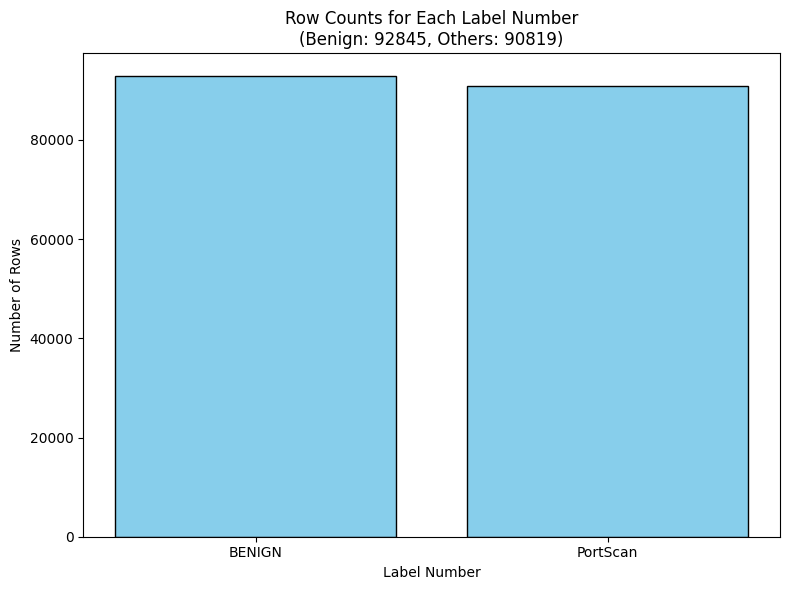

Train Accuracy: 0.98
Test Accuracy: 0.98

Confusion Matrix:
[[26955   811]
 [   38 27296]]

Metrics for each class:
Class 0 -> TP: 26955, FP: 38, FN: 811, TN: 27296
Class 1 -> TP: 27296, FP: 811, FN: 38, TN: 26955

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     27766
           1       0.97      1.00      0.98     27334

    accuracy                           0.98     55100
   macro avg       0.98      0.98      0.98     55100
weighted avg       0.98      0.98      0.98     55100



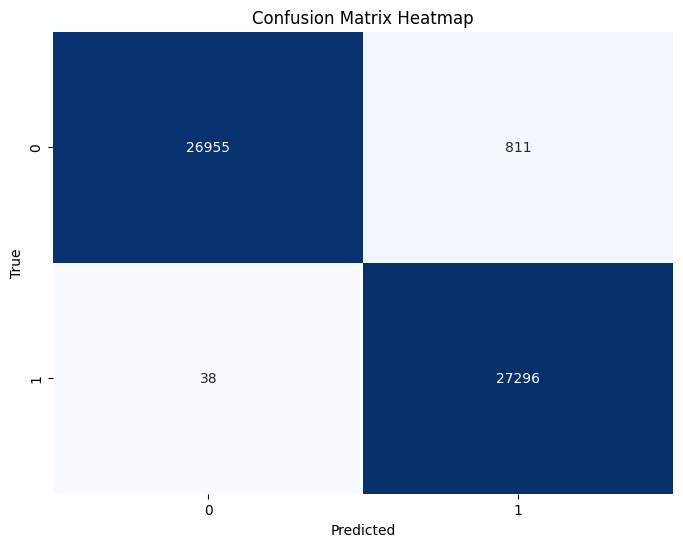

Runtime: 5.51 minutes
Model saved successfully!


In [14]:
portDataframe = pd.read_csv('CICIDS_Port.csv')
portDataframe.columns = portDataframe.columns.str.strip()
portDataframe = filterBenignValues(portDataframe, 0.75)

# check for duplicates in the subset of selected features
duplicates_mask = portDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
portDataframe = portDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {portDataframe.shape}")

# select relevant columns 
portDataframe = portDataframe[selectedColumns]

# train-test split
X = portDataframe.drop(columns=['Label'])
y = portDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'PortScan': 1
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'PortScan'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale)

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'port_svm_model.pkl')  
print("Model saved successfully!")

## Only DoS

Number of duplicate rows based on selected features: 67525
Shape of dataset after removing duplicates: (405163, 79)
(283614, 22) (121549, 22) (283614,) (121549,)


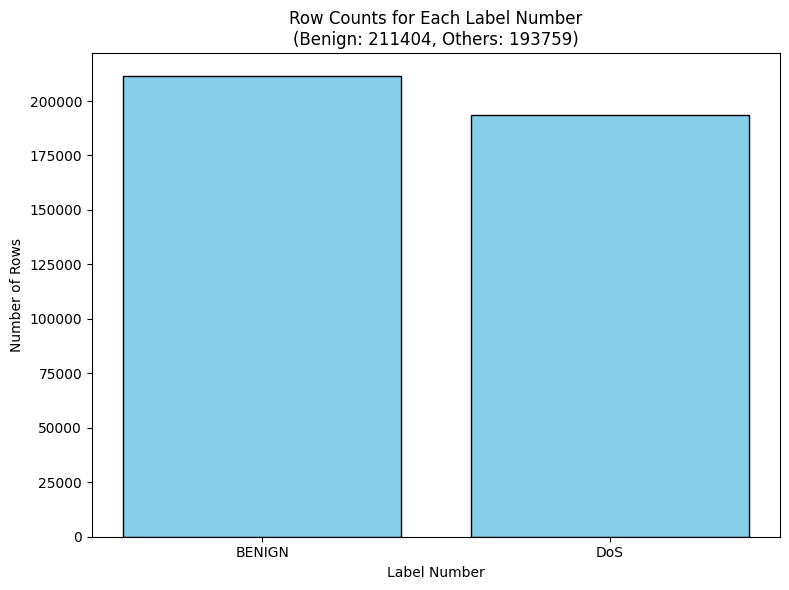

Train Accuracy: 0.97
Test Accuracy: 0.97

Confusion Matrix:
[[62437  1141]
 [ 1926 56045]]

Metrics for each class:
Class 0 -> TP: 62437, FP: 1926, FN: 1141, TN: 56045
Class 1 -> TP: 56045, FP: 1141, FN: 1926, TN: 62437

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     63578
           1       0.98      0.97      0.97     57971

    accuracy                           0.97    121549
   macro avg       0.98      0.97      0.97    121549
weighted avg       0.97      0.97      0.97    121549



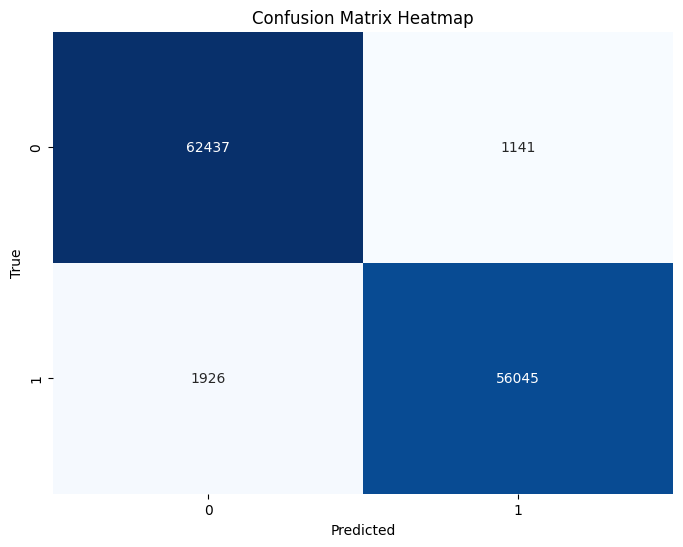

Runtime: 12.12 minutes
Model saved successfully!


In [ ]:
dosDataframe = pd.read_csv('CICIDS_DoS.csv')
dosDataframe.columns = dosDataframe.columns.str.strip()
dosDataframe = filterBenignValues(dosDataframe, 0.5)

# check for duplicates in the subset of selected features
duplicates_mask = dosDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
dosDataframe = dosDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {dosDataframe.shape}")

# select relevant columns 
dosDataframe = dosDataframe[selectedColumns]

# train-test split
X = dosDataframe.drop(columns=['Label'])
y = dosDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DoS GoldenEye': 1, 'DoS Hulk': 1, 'DoS Slowhttptest': 1, 'DoS slowloris': 1, 'Heartbleed': 1,
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'DoS'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale)

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'dos_svm_model.pkl')  
print("Model saved successfully!")

## Only DDoS

Number of duplicate rows based on selected features: 2633
Shape of dataset after removing duplicates: (223112, 79)
(156178, 22) (66934, 22) (156178,) (66934,)


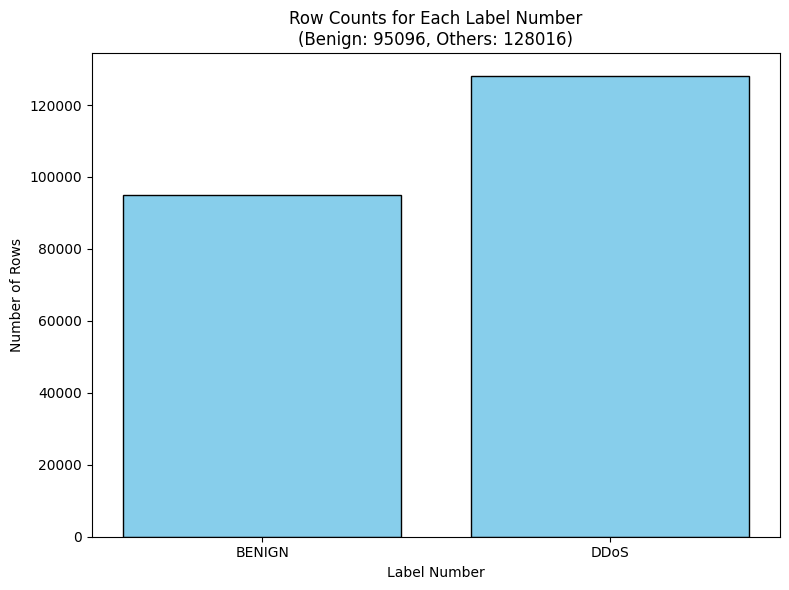

Train Accuracy: 0.99
Test Accuracy: 0.99

Confusion Matrix:
[[27732   723]
 [   49 38430]]

Metrics for each class:
Class 0 -> TP: 27732, FP: 49, FN: 723, TN: 38430
Class 1 -> TP: 38430, FP: 723, FN: 49, TN: 27732

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     28455
           1       0.98      1.00      0.99     38479

    accuracy                           0.99     66934
   macro avg       0.99      0.99      0.99     66934
weighted avg       0.99      0.99      0.99     66934



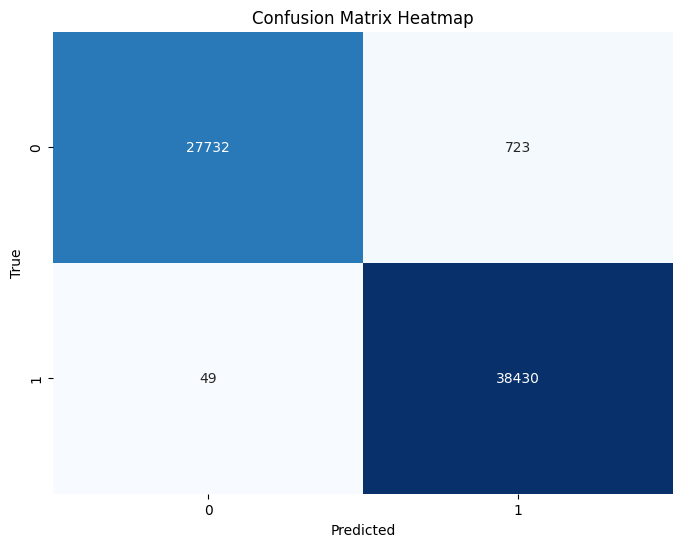

Runtime: 1.75 minutes
Model saved successfully!


In [ ]:
ddosDataframe = pd.read_csv('CICIDS_DDoS.csv')
ddosDataframe.columns = ddosDataframe.columns.str.strip()

# check for duplicates in the subset of selected features
duplicates_mask = ddosDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
ddosDataframe = ddosDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {ddosDataframe.shape}")

# select relevant columns 
ddosDataframe = ddosDataframe[selectedColumns]

# train-test split
X = ddosDataframe.drop(columns=['Label'])
y = ddosDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DDoS': 1,
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'DDoS'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale)

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'ddos_svm_model.pkl')  
print("Model saved successfully!")

## Port Scanning and DoS

Number of duplicate rows based on selected features: 134216
Shape of dataset after removing duplicates: (476035, 79)
(333224, 22) (142811, 22) (333224,) (142811,)


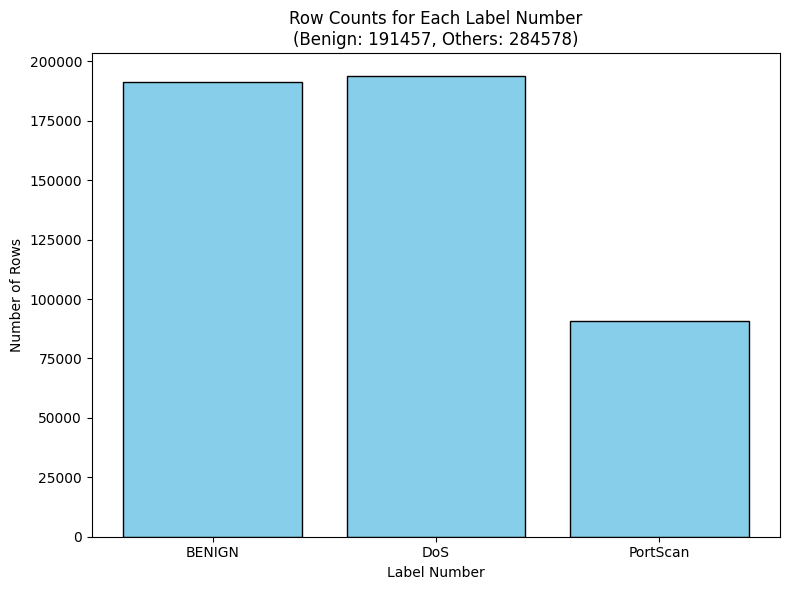

Train Accuracy: 0.98
Test Accuracy: 0.98

Confusion Matrix:
[[56305  1057   129]
 [ 1950 56097     0]
 [  308    20 26945]]

Metrics for each class:
Class 0 -> TP: 56305, FP: 2258, FN: 1186, TN: 83062
Class 1 -> TP: 56097, FP: 1077, FN: 1950, TN: 83687
Class 2 -> TP: 26945, FP: 129, FN: 328, TN: 115409

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97     57491
           1       0.98      0.97      0.97     58047
           2       1.00      0.99      0.99     27273

    accuracy                           0.98    142811
   macro avg       0.98      0.98      0.98    142811
weighted avg       0.98      0.98      0.98    142811



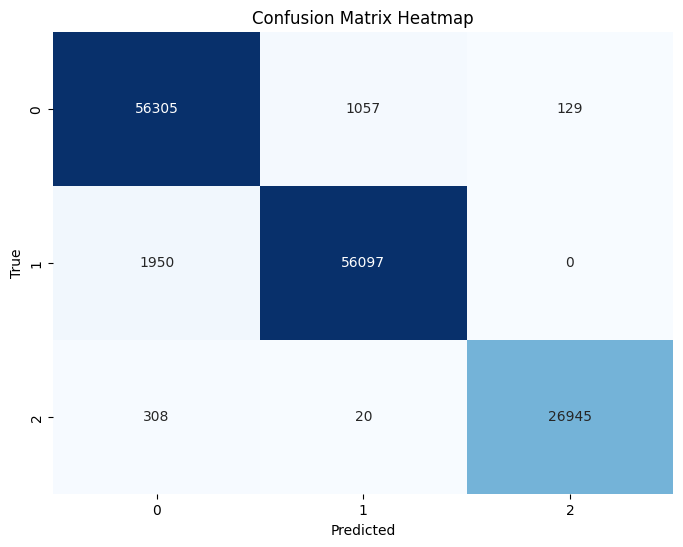

Runtime: 35.12 minutes
Model saved successfully!


In [ ]:
portDataframe = pd.read_csv('CICIDS_Port.csv')
portDataframe.columns = portDataframe.columns.str.strip()
portDataframe = filterBenignValues(portDataframe, 0.35)

dosDataframe = pd.read_csv('CICIDS_DoS.csv')
dosDataframe.columns = dosDataframe.columns.str.strip()
dosDataframe = filterBenignValues(dosDataframe, 0.35)

# creating a single dataframe with bengin, ddos and portscannig
mergedDataframe = pd.concat([dosDataframe, portDataframe], axis=0)
mergedDataframe = mergedDataframe.sample(frac=1, random_state=42).reset_index(drop=True)

# check for duplicates in the subset of selected features
duplicates_mask = mergedDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
mergedDataframe = mergedDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {mergedDataframe.shape}")

# select relevant columns 
mergedDataframe = mergedDataframe[selectedColumns]

# train-test split
X = mergedDataframe.drop(columns=['Label'])
y = mergedDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DoS GoldenEye': 1, 'DoS Hulk': 1, 'DoS Slowhttptest': 1, 'DoS slowloris': 1, 'Heartbleed': 1,
    'PortScan': 2,
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'DoS', 'PortScan'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale)

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'port_dos_svm_model.pkl')  
print("Model saved successfully!")

## Port Scanning DoS and DDoS - Even distribution of the data

Number of duplicate rows based on selected features: 135519
Shape of dataset after removing duplicates: (636960, 79)
(445872, 22) (191088, 22) (445872,) (191088,)


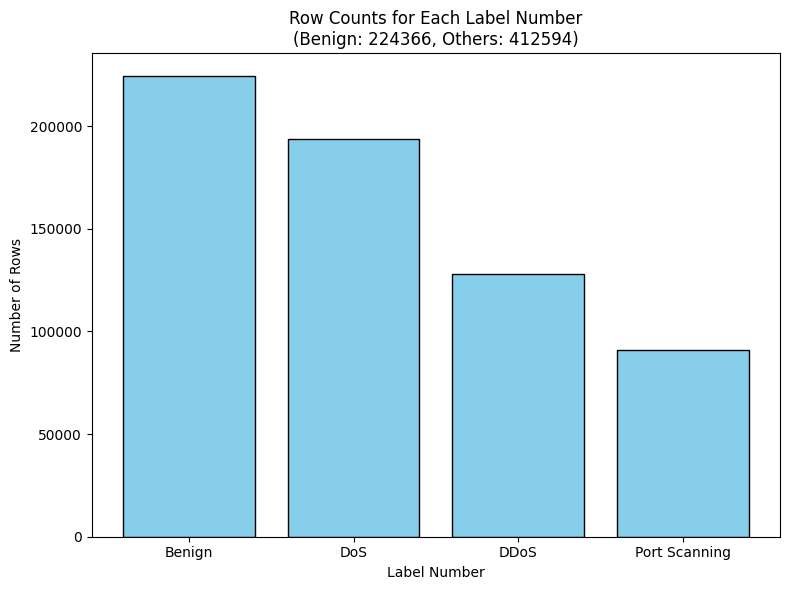

Train Accuracy: 0.97
Test Accuracy: 0.97

Confusion Matrix:
[[63876  1205  1975   142]
 [ 1966 56215    34     0]
 [   25    10 38364     0]
 [  311    17    33 26915]]

Metrics for each class:
Class 0 -> TP: 63876, FP: 2302, FN: 3322, TN: 121588
Class 1 -> TP: 56215, FP: 1232, FN: 2000, TN: 131641
Class 2 -> TP: 38364, FP: 2042, FN: 35, TN: 150647
Class 3 -> TP: 26915, FP: 142, FN: 361, TN: 163670

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     67198
           1       0.98      0.97      0.97     58215
           2       0.95      1.00      0.97     38399
           3       0.99      0.99      0.99     27276

    accuracy                           0.97    191088
   macro avg       0.97      0.98      0.97    191088
weighted avg       0.97      0.97      0.97    191088



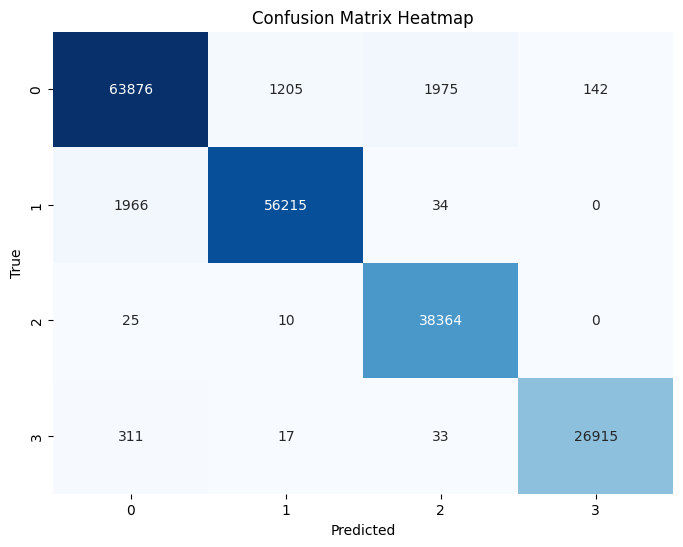

Runtime: 81.02 minutes
Model saved successfully!


In [ ]:
portDataframe = pd.read_csv('CICIDS_Port.csv')
portDataframe.columns = portDataframe.columns.str.strip()
portDataframe = filterBenignValues(portDataframe, 0.35)

dosDataframe = pd.read_csv('CICIDS_DoS.csv')
dosDataframe.columns = dosDataframe.columns.str.strip()
dosDataframe = filterBenignValues(dosDataframe, 0.35)

ddosDataframe = pd.read_csv('CICIDS_DDoS.csv')
ddosDataframe.columns = ddosDataframe.columns.str.strip()
ddosDataframe = filterBenignValues(ddosDataframe, 0.35)

# creating a single dataframe with bengin, ddos and portscannig
mergedDataframe = pd.concat([dosDataframe, ddosDataframe, portDataframe], axis=0)
mergedDataframe = mergedDataframe.sample(frac=1, random_state=42).reset_index(drop=True)

# check for duplicates in the subset of selected features
duplicates_mask = mergedDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
mergedDataframe = mergedDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {mergedDataframe.shape}")

# select relevant columns 
mergedDataframe = mergedDataframe[selectedColumns]

# train-test split
X = mergedDataframe.drop(columns=['Label'])
y = mergedDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DoS GoldenEye': 1, 'DoS Hulk': 1, 'DoS Slowhttptest': 1, 'DoS slowloris': 1, 'Heartbleed': 1,
    'DDoS': 2, 
    'PortScan': 3,
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y)

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale)

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'port_dos_ddos_even_svm_model.pkl')  
print("Model saved successfully!")

## Port Scanning DoS and DDoS - 100% of the data

Number of duplicate rows based on selected features: 164970
Shape of dataset after removing duplicates: (1039945, 79)
(727961, 22) (311984, 22) (727961,) (311984,)


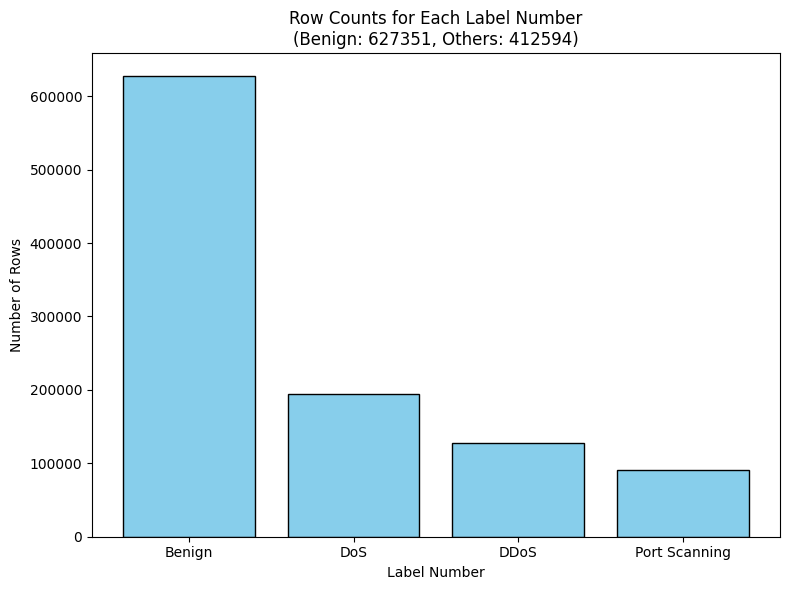

Train Accuracy: 0.97
Test Accuracy: 0.97

Confusion Matrix:
[[180065   3151   4871    416]
 [  2028  55801     45      0]
 [    25      6  38431      0]
 [   318     16     33  26778]]

Metrics for each class:
Class 0 -> TP: 180065, FP: 2371, FN: 8438, TN: 121110
Class 1 -> TP: 55801, FP: 3173, FN: 2073, TN: 250937
Class 2 -> TP: 38431, FP: 4949, FN: 31, TN: 268573
Class 3 -> TP: 26778, FP: 416, FN: 367, TN: 284423

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97    188503
           1       0.95      0.96      0.96     57874
           2       0.89      1.00      0.94     38462
           3       0.98      0.99      0.99     27145

    accuracy                           0.97    311984
   macro avg       0.95      0.98      0.96    311984
weighted avg       0.97      0.97      0.97    311984



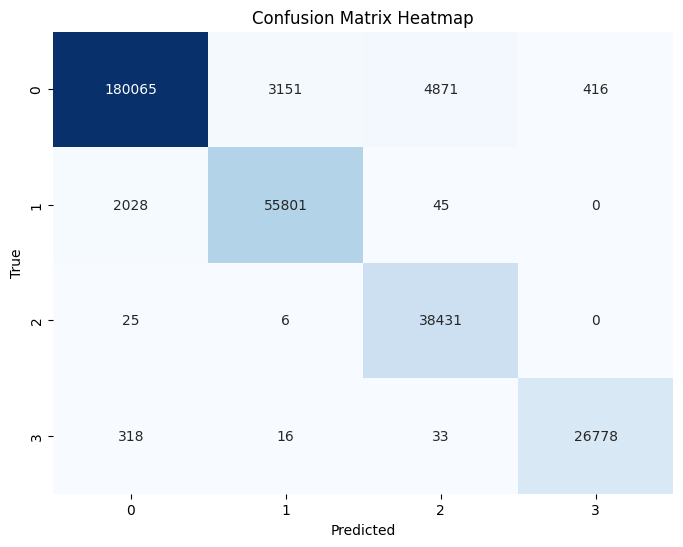

Runtime: 232.14 minutes
Model saved successfully!


In [ ]:
portDataframe = pd.read_csv('CICIDS_Port.csv')
portDataframe.columns = portDataframe.columns.str.strip()

dosDataframe = pd.read_csv('CICIDS_DoS.csv')
dosDataframe.columns = dosDataframe.columns.str.strip()

ddosDataframe = pd.read_csv('CICIDS_DDoS.csv')
ddosDataframe.columns = ddosDataframe.columns.str.strip()

# creating a single dataframe with bengin, ddos and portscannig
mergedDataframe = pd.concat([dosDataframe, ddosDataframe, portDataframe], axis=0)
mergedDataframe = mergedDataframe.sample(frac=1, random_state=42).reset_index(drop=True)

# check for duplicates in the subset of selected features
duplicates_mask = mergedDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
mergedDataframe = mergedDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {mergedDataframe.shape}")

# select relevant columns 
mergedDataframe = mergedDataframe[selectedColumns]

# train-test split
X = mergedDataframe.drop(columns=['Label'])
y = mergedDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'DoS GoldenEye': 1, 'DoS Hulk': 1, 'DoS Slowhttptest': 1, 'DoS slowloris': 1, 'Heartbleed': 1,
    'DDoS': 2, 
    'PortScan': 3,
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y)

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale)

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'port_dos_ddos_full_svm_model.pkl')  
print("Model saved successfully!")

---

## Checking the data

In [6]:
portDataframe = pd.read_csv('CICIDS_Port.csv')
portDataframe.columns = portDataframe.columns.str.strip()
portDataframe = filterBenignValues(portDataframe, 0.75)

# check for duplicates in the subset of selected features
duplicates_mask = portDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
portDataframe = portDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {portDataframe.shape}")

# select relevant columns 
portDataframe = portDataframe[selectedColumns]

attackDataframe = portDataframe[portDataframe['Label'] == 'PortScan']
attackDataframe = attackDataframe[555:560]

for index, row in attackDataframe.iterrows():
    print(f"Row {index + 1}:")
    for column in attackDataframe.columns:
        print(f"  {column}: {row[column]}")
    print("-" * 20)
    print('\n\n')

Number of duplicate rows based on selected features: 70919
Shape of dataset after removing duplicates: (183664, 79)
Row 88002:
  Destination Port: 7938
  Total Length of Fwd Packets: 2
  Fwd Packet Length Max: 2
  Fwd Packet Length Mean: 2.0
  Bwd Packet Length Max: 6
  Bwd Packet Length Min: 6
  Bwd Packet Length Mean: 6.0
  Bwd Packet Length Std: 0.0
  Bwd IAT Total: 0
  Bwd IAT Max: 0
  Min Packet Length: 2
  Max Packet Length: 6
  Packet Length Mean: 3.333333333
  Packet Length Std: 2.309401077
  Packet Length Variance: 5.333333333
  SYN Flag Count: 0
  PSH Flag Count: 1
  URG Flag Count: 0
  Average Packet Size: 5.0
  Avg Fwd Segment Size: 2.0
  Avg Bwd Segment Size: 6.0
  Subflow Fwd Bytes: 2
  Label: PortScan
--------------------



Row 88003:
  Destination Port: 4900
  Total Length of Fwd Packets: 2
  Fwd Packet Length Max: 2
  Fwd Packet Length Mean: 2.0
  Bwd Packet Length Max: 6
  Bwd Packet Length Min: 6
  Bwd Packet Length Mean: 6.0
  Bwd Packet Length Std: 0.0
  Bwd IAT T

## Only PortScan - Updated Dataset

In [26]:
selectedColumns = [
    'Dst Port', 'Total Length of Fwd Packet', 'Fwd Packet Length Max',
    'Fwd Packet Length Mean', 'Bwd Packet Length Max', 'Bwd Packet Length Min',
    'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Bwd IAT Total',
    'Bwd IAT Max', 'Packet Length Min', 'Packet Length Max', 'Packet Length Mean',
    'Packet Length Std', 'Packet Length Variance', 'SYN Flag Count', 'PSH Flag Count', 'URG Flag Count',
    'Average Packet Size', 'Fwd Segment Size Avg', 'Bwd Segment Size Avg',
    'Subflow Fwd Bytes', 'Label'
]

In [27]:
portDataframe = pd.read_csv('CICIDS_Port_2.csv')
portDataframe.columns = portDataframe.columns.str.strip()
portDataframe = filterBenignValues(portDataframe, 0.57)

# check for duplicates in the subset of selected features
duplicates_mask = portDataframe.duplicated(keep='first')
num_duplicates = duplicates_mask.sum()
print(f"Number of duplicate rows based on selected features: {num_duplicates}")

# remove duplicates directly
portDataframe = portDataframe.drop_duplicates(keep='first')
print(f"Shape of dataset after removing duplicates: {portDataframe.shape}")

# select relevant columns 
portDataframe = portDataframe[selectedColumns]
portDataframe = portDataframe[(portDataframe['Label'] == 'BENIGN') | (portDataframe['Label'] == 'Portscan')]
portDataframe.head(-5)

Number of duplicate rows based on selected features: 0
Shape of dataset after removing duplicates: (423483, 91)


,Dst Port,Total Length of Fwd Packet,Fwd Packet Length Max,Fwd Packet Length Mean,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Bwd IAT Total,Bwd IAT Max,...,Packet Length Std,Packet Length Variance,SYN Flag Count,PSH Flag Count,URG Flag Count,Average Packet Size,Fwd Segment Size Avg,Bwd Segment Size Avg,Subflow Fwd Bytes,Label
256723,443,699,342,30.391304,2636,0,308.954545,728.916317,115402692,10028788,...,526.103364,276784.749495,2,9,0,166.577778,30.391304,308.954545,15,BENIGN
35292,53,100,50,50.000000,78,78,78.000000,0.000000,4,4,...,16.165808,261.333333,0,0,0,64.000000,50.000000,78.000000,25,BENIGN
174928,123,48,48,48.000000,48,48,48.000000,0.000000,0,0,...,0.000000,0.000000,0,0,0,48.000000,48.000000,48.000000,24,BENIGN
485359,80,263,263,10.115385,2896,0,727.200000,934.816916,115326497,11196882,...,742.877566,551867.078431,2,2,0,361.627451,10.115385,727.200000,5,BENIGN
23934,53,90,45,45.000000,61,61,61.000000,0.000000,48,48,...,9.237604,85.333333,0,0,0,53.000000,45.000000,61.000000,22,BENIGN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
547539,1009,0,0,0.000000,0,0,0.000000,0.000000,0,0,...,0.000000,0.000000,1,0,0,0.000000,0.000000,0.000000,0,Portscan
547540,50001,0,0,0.000000,0,0,0.000000,0.000000,0,0,...,0.000000,0.000000,1,0,0,0.000000,0.000000,0.000000,0,Portscan
547541,3268,0,0,0.000000,0,0,0.000000,0.000000,0,0,...,0.000000,0.000000,1,0,0,0.000000,0.000000,0.000000,0,Portscan
547542,5862,0,0,0.000000,0,0,0.000000,0.000000,0,0,...,0.000000,0.000000,1,0,0,0.000000,0.000000,0.000000,0,Portscan


(226475, 22) (97061, 22) (226475,) (97061,)


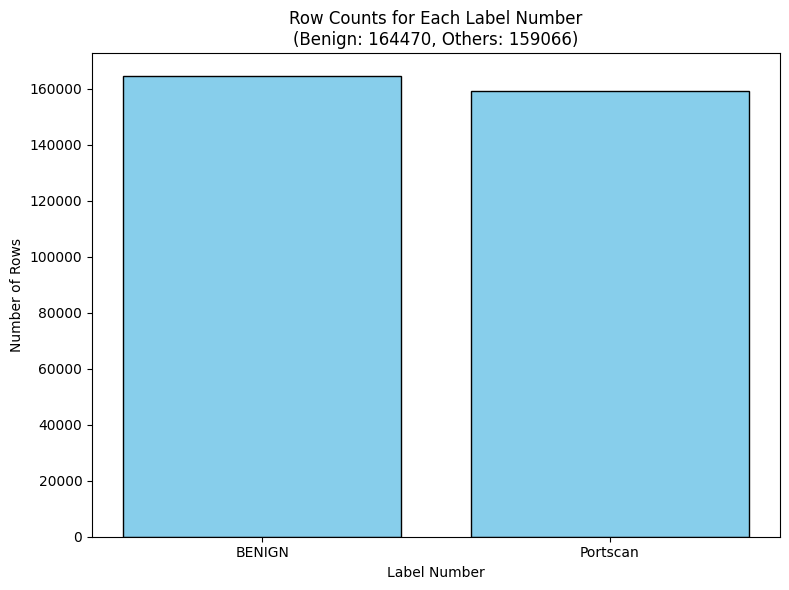

Train Accuracy: 1.00
Test Accuracy: 1.00

Confusion Matrix:
[[49059   317]
 [   26 47659]]

Metrics for each class:
Class 0 -> TP: 49059, FP: 26, FN: 317, TN: 47659
Class 1 -> TP: 47659, FP: 317, FN: 26, TN: 49059

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     49376
           1       0.99      1.00      1.00     47685

    accuracy                           1.00     97061
   macro avg       1.00      1.00      1.00     97061
weighted avg       1.00      1.00      1.00     97061



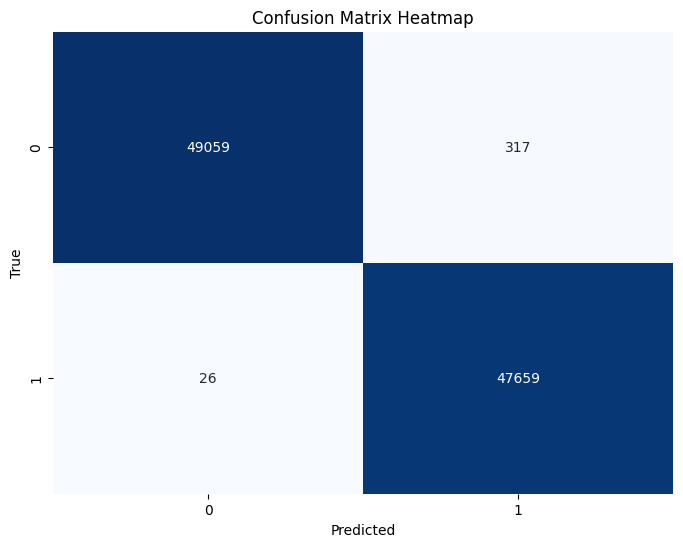

Runtime: 0.81 minutes
Model saved successfully!


In [28]:
# train-test split
X = portDataframe.drop(columns=['Label'])
y = portDataframe['Label']

mappingLabels = {
    'BENIGN': 0, 
    'Portscan': 1
}
y = y.map(mappingLabels)

# train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
count_and_plot(y, ['BENIGN', 'Portscan'])

# remove null and scale
remove_null_and_infi(X_train, X_test)
columnsToScale = [column for column in X_train.columns if column != 'Label'] 
X_train_scaled, X_test_scaled = scaleData(scaler, X_train, X_test, columnsToScale)

# train the model and save the output
start_time = time.time()
model = train_and_evaluate_svm(X_train_scaled, X_test_scaled, y_train, y_test)
runtime = (time.time() - start_time)/60
print(f"Runtime: {runtime:.2f} minutes")

joblib.dump(model, 'port_svm_model_2.pkl')  
print("Model saved successfully!")